### Imports

In [1]:
import pandas as pd
import numpy as np 
import QAOA_Tester as qtee
import os

### Functions

In [2]:
def combine_dfs(dfs):
    combined_df = pd.concat(dfs)
    combined_df.drop(columns='Unnamed: 0', inplace=True)
    combined_df = combined_df.sort_values(by='layers')
    combined_df.reset_index(drop=True, inplace=True)
    return combined_df

In [3]:
def load_dfs_from(dir_name):
    files_in_dir = os.listdir(dir_name)
    files_in_dir = [file for file in files_in_dir if file.endswith('.csv')]
    dfs = []
    for file_name in files_in_dir:
        dfs.append(pd.read_csv(f'{dir_name}/{file_name}'))
    
    return dfs

    

In [4]:
def reverse_results(df):
    problem_data = df.iloc[0]['problem']
    problem_data = eval(problem_data)
    problem = qtee.ProblemGenerator.from_dict(problem_data)
    def reverse_and_evaluate(solution):
        solution = eval(solution)
        reversed_solutions = []
        for sol in solution:
            reversed_solution = sol[0][::-1]
            reversed_cost = problem.qubo.objective.evaluate(reversed_solution)
            reversed_solutions.append((reversed_solution, reversed_cost))
        return reversed_solutions
    
    reversed_df = df.copy()
    reversed_df['solutions'] = df['solutions'].apply(lambda x: reverse_and_evaluate(x))
    return reversed_df
    

In [5]:
# def compute_average_cost(df):
#     # Group all rows by the number of layers
#     grouped_df = df.groupby('layers')
#     # Get all solutions for each layer
#     solutions = grouped_df['solutions'].apply(lambda x: [item for sublist in x for item in sublist])
    
#     # Initialize an empty list to store costs
#     costs = []

#     # Iterate over each layer's solutions
#     for layer, solution in solutions.items():
#         layer_cost = 0
#         count = 0
        
#         for rep in solution:
#             if isinstance(rep, list) and isinstance(rep[0], tuple):
#                 # Structure is a list of tuples
#                 layer_cost += sum([sol[1] for sol in rep])
#                 count += len(rep)
#             elif isinstance(rep, tuple):
#                 # Structure is a single tuple
#                 layer_cost += rep[1]
#                 count += 1
        
#         # Compute the average cost for the layer
#         if count > 0:
#             layer_cost /= count
#         costs.append((layer, layer_cost))

#     # Return a dataframe with the average cost for each layer
#     return pd.DataFrame(costs, columns=['layers', 'cost'])


def compute_average_cost_and_time(df):
    # Group all rows by the number of layers
    grouped_df = df.groupby('layers')
    # Get all solutions for each layer
    solutions = grouped_df['solutions'].apply(lambda x: [item for sublist in x for item in sublist])
    
    # Get all times for each layer and handle different formats
    def flatten_times(times):
        if isinstance(times.iloc[0], list):
            return [item for sublist in times for item in sublist]
        elif isinstance(times.iloc[0], str):
            return [float(item) for sublist in times for item in eval(sublist)]
        else:
            return times.tolist()

    times = grouped_df['time'].apply(flatten_times)
    
    # Initialize lists to store costs and times
    costs = []
    avg_times = []

    # Iterate over each layer's solutions
    for layer, solution in solutions.items():
        layer_cost = 0
        count = 0
        
        for rep in solution:
            if isinstance(rep, list) and isinstance(rep[0], tuple):
                # Structure is a list of tuples
                layer_cost += sum([sol[1] for sol in rep])
                count += len(rep)
            elif isinstance(rep, tuple):
                # Structure is a single tuple
                layer_cost += rep[1]
                count += 1
        
        # Compute the average cost for the layer
        if count > 0:
            layer_cost /= count
        costs.append((layer, layer_cost))

    # Iterate over each layer's times
    for layer, time in times.items():
        avg_time = sum(time) / len(time)
        avg_times.append((layer, avg_time))

    # Combine costs and times into a single DataFrame
    costs_df = pd.DataFrame(costs, columns=['layers', 'cost'])
    times_df = pd.DataFrame(avg_times, columns=['layers', 'average_time'])
    result_df = costs_df.merge(times_df, on='layers')

    return result_df

In [6]:
import matplotlib.pyplot as plt

def plot_average_costs(data, best_cost=None):
    colors = qtee.utils.custom_colors
    key_to_color = {'Optimal Backend': 'blue', 'Noisy Backend': 'orange'}
    for key, df in data.items():
        plt.plot(df['layers'], -df['cost'], label=key, color=colors[key_to_color[key]]['dark'])
    if best_cost:
        point1 = (1, best_cost)
        point2 = (30, best_cost)
        max_value_line = [point1, point2]
        plt.plot(*zip(*max_value_line), color='red', linestyle='--', label='Best Cost')
        plt.ylim(0, best_cost+ 0.1*best_cost)
    plt.xlabel('Layers')
    plt.ylabel('Average Cost')
    plt.legend()
    return plt


In [7]:
def plot_average_times(data):
    colors = qtee.utils.custom_colors
    key_to_color = {'Optimal Backend': 'blue', 'Noisy Backend': 'orange'}
    for key, df in data.items():
        plt.plot(df['layers'], df['average_time'], label=key, color=colors[key_to_color[key]]['dark'])
    plt.xlabel('Layers')
    plt.ylabel('Average Time (s)')
    plt.legend()
    return plt

In [62]:
def get_costs_and_times(df):
    # Group all rows by the number of layers
    grouped_df = df.groupby('layers')
    # Get all solutions for each layer
    solutions = grouped_df['solutions'].apply(lambda x: [item for sublist in x for item in sublist])
    
    # Get all times for each layer and handle different formats
    def flatten_times(times):
        if isinstance(times.iloc[0], list):
            return [item for sublist in times for item in sublist]
        elif isinstance(times.iloc[0], str):
            return [float(item) for sublist in times for item in eval(sublist)]
        else:
            return times.tolist()

    times = grouped_df['time'].apply(flatten_times)
    
    # Initialize lists to store costs and times
    costs = []
    time_list = []
    # Iterate over each layer's solutions
    for layer, solution in solutions.items():
        layer_cost = []
        
        for rep in solution:
            if isinstance(rep, list) and isinstance(rep[0], tuple):
                # Structure is a list of tuples
                layer_cost.extend([-sol[1] for sol in rep])
            elif isinstance(rep, tuple):
                # Structure is a single tuple
                layer_cost.append(-rep[1])
        costs.append((layer, layer_cost))
    
    # Iterate over each layer's times
    for layer, time in times.items():
        time_list.append((layer, time))

    # Combine costs and times into a single DataFrame
    costs_df = pd.DataFrame(costs, columns=['layers', 'cost'])
    times_df = pd.DataFrame(time_list, columns=['layers', 'times'])
    result_df = costs_df.merge(times_df, on='layers')
    
    return result_df

In [124]:
import seaborn as sns
def plot_average_costs_with_ci(data, best_cost=None, percentile=80, smoothing_factor=1):
    colors = qtee.utils.custom_colors
    key_to_color = {'Optimal Backend': 'blue', 'Noisy Backend': 'orange'}
    
    # plt.figure(figsize=(10, 6))
    
    alpha = 0.7
    for key, df in data.items():
        # Calculate mean and percentiles for each layer
        df = df.explode('cost').reset_index(drop=True)
        df['cost'] = df['cost'].astype(float)
        summary = df.groupby('layers').agg(
            mean_cost=('cost', 'mean'),
            lower_percentile=('cost', lambda x: np.percentile(x, (100 - percentile) / 2)),
            upper_percentile=('cost', lambda x: np.percentile(x, 100 - (100 - percentile) / 2))
        ).reset_index()
        
        ax = sns.lineplot(
            x='layers', 
            y='mean_cost', 
            data=summary, 
            label=key, 
            color=colors[key_to_color[key]]['dark'], 
            errorbar=None
        )
        # Smoothing the lower and upper percentiles
        lower_smoothed = summary['lower_percentile'].rolling(window=smoothing_factor, min_periods=1).mean()
        upper_smoothed = summary['upper_percentile'].rolling(window=smoothing_factor, min_periods=1).mean()
        
        plt.fill_between(
            summary['layers'], 
            lower_smoothed, 
            upper_smoothed, 
            color=colors[key_to_color[key]]['light'], 
            alpha=alpha
        )
        alpha /= 1.5
    
    if best_cost:
        point1 = (1, best_cost)
        point2 = (30, best_cost)
        max_value_line = [point1, point2]
        plt.plot(*zip(*max_value_line), color='red', linestyle='--', label='Best Cost')
        plt.ylim(0, best_cost+ 0.1*best_cost)

    plt.xlabel('Layers')
    plt.ylabel('Average Cost')
    # plt.title('Average Costs with Confidence Intervals')
    plt.legend()
    return plt

### Load data, combine it and compute average

In [126]:
def plot_average_optimal_noisy(number_of_nodes):
    optimal_dfs = load_dfs_from(f'results_maxcut_{number_of_nodes}/optimal')
    noisy_dfs = load_dfs_from(f'results_maxcut_{number_of_nodes}/noisy')

    noisy_df = combine_dfs(noisy_dfs)    
    corrected_noisy = reverse_results(noisy_df)
    # corrected_noisy = noisy_df
    # print(corrected_noisy)
    # noisy_average = compute_average_cost(corrected_noisy)
    noisy_average = compute_average_cost_and_time(corrected_noisy)
    noisy_layers = get_costs_and_times(corrected_noisy)

    optimal_df = combine_dfs(optimal_dfs)
    corrected_optimal = reverse_results(optimal_df)
    # print(corrected_optimal)
    # optimal_avcerage = compute_average_cost(corrected_optimal)
    optimal_average = compute_average_cost_and_time(corrected_optimal)
    optimal_layers = get_costs_and_times(corrected_optimal)

    data = {'Optimal Backend': optimal_average, 'Noisy Backend': noisy_average}

    problem = qtee.ProblemGenerator.from_dict(eval(optimal_dfs[0].iloc[0]['problem']))
    plt = plot_average_costs(data, problem.solution[1])
    plt.savefig(f'plots/average_costs_{number_of_nodes}.pdf')
    plt.show()

    time_plt = plot_average_times(data)
    time_plt.savefig(f'plots/average_times_{number_of_nodes}.pdf')
    time_plt.show()

    data_layers = {'Noisy Backend': noisy_layers, 'Optimal Backend': optimal_layers}

    plt_ci = plot_average_costs_with_ci(data_layers, problem.solution[1])
    plt_ci.savefig(f'plots/average_costs_ci_{number_of_nodes}.pdf')
    plt_ci.show()
    # print(problem.solution)


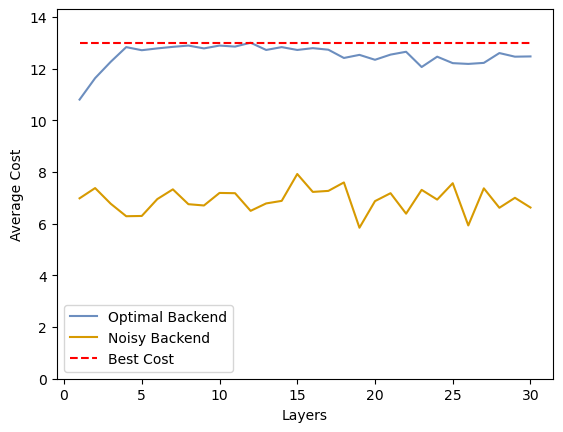

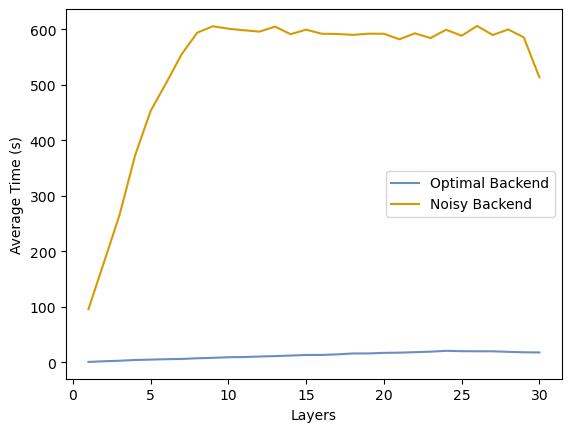

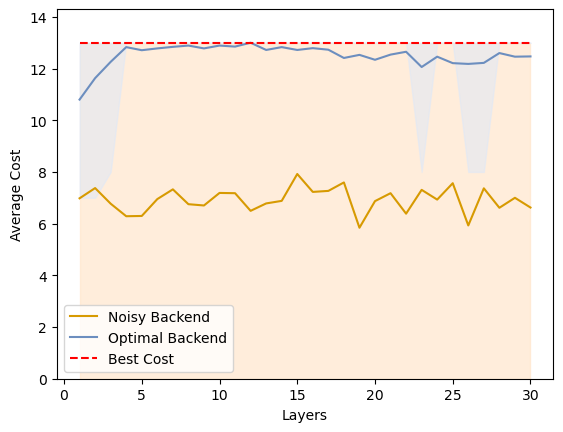

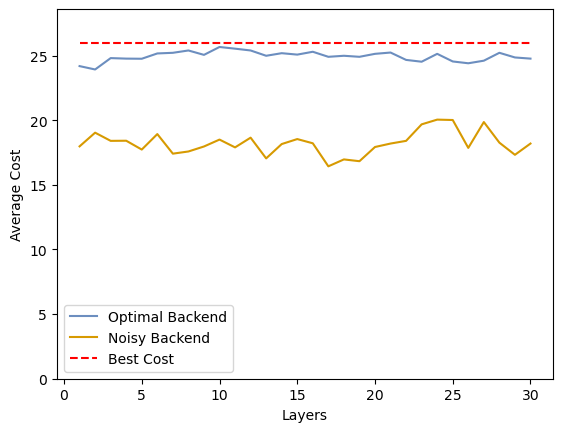

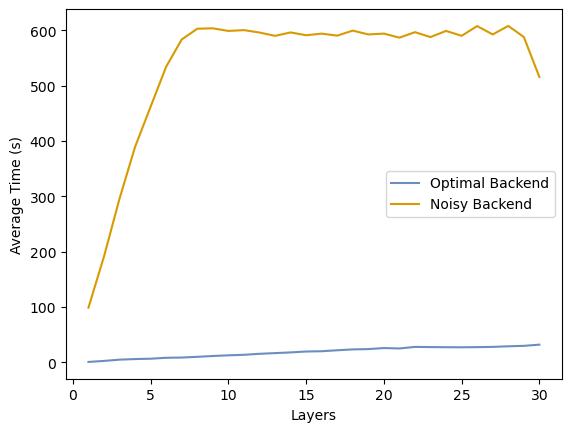

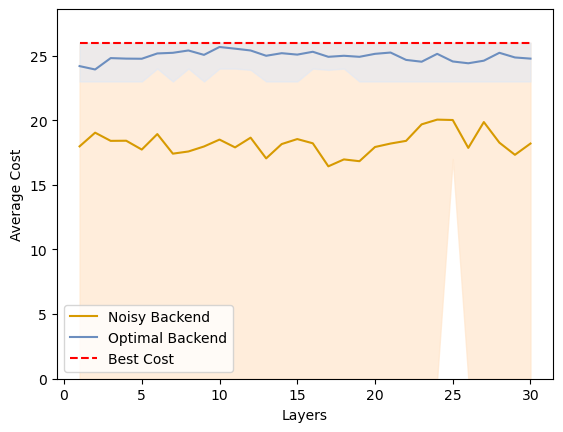

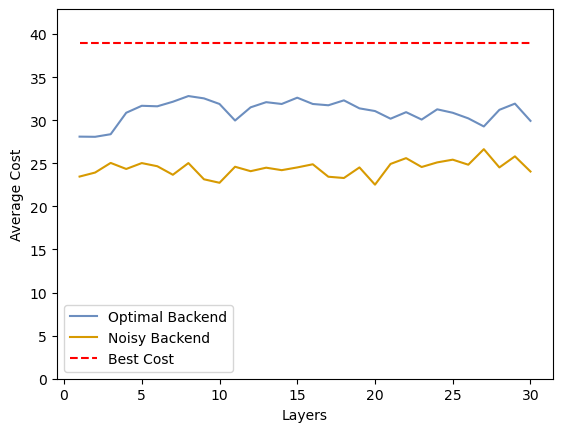

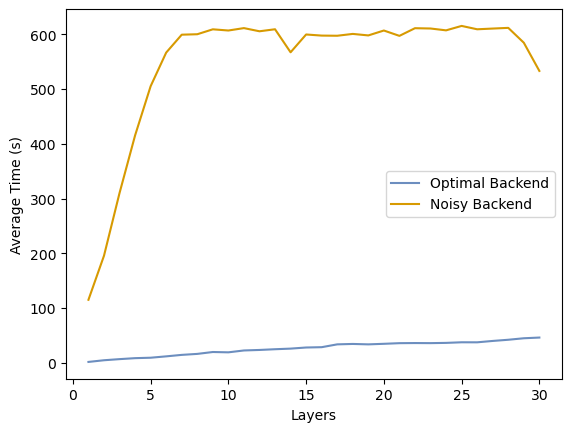

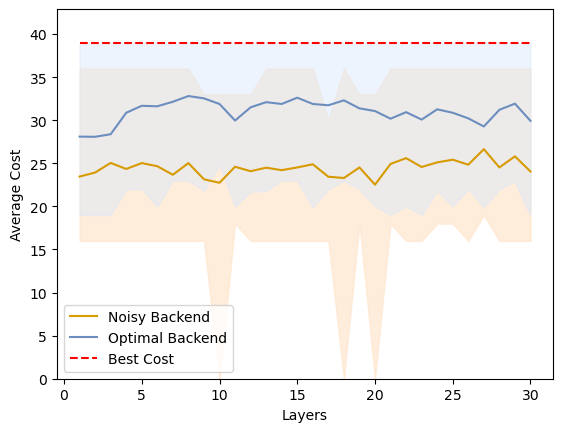

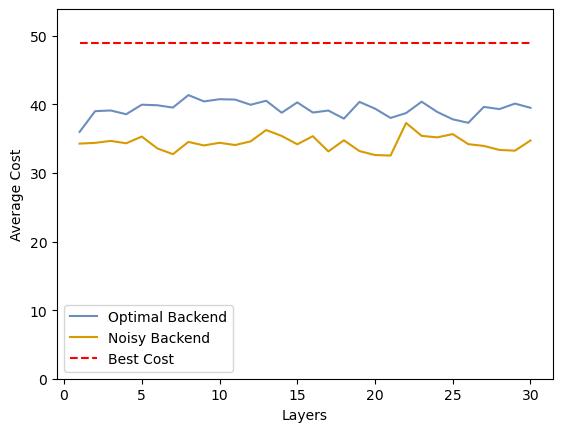

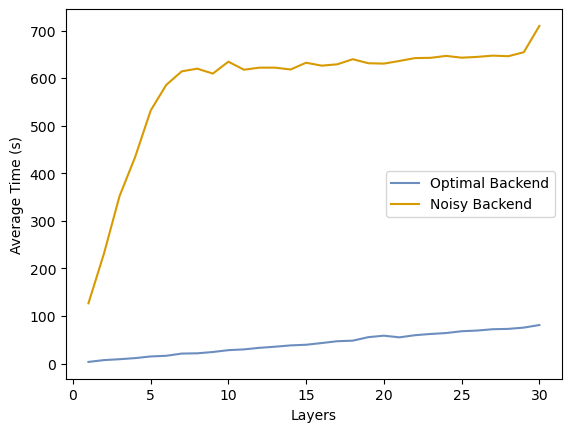

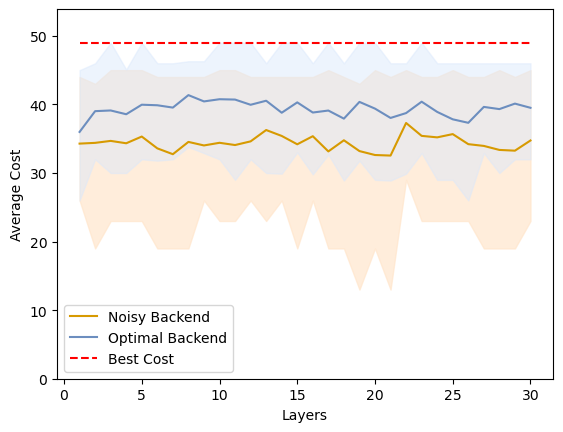

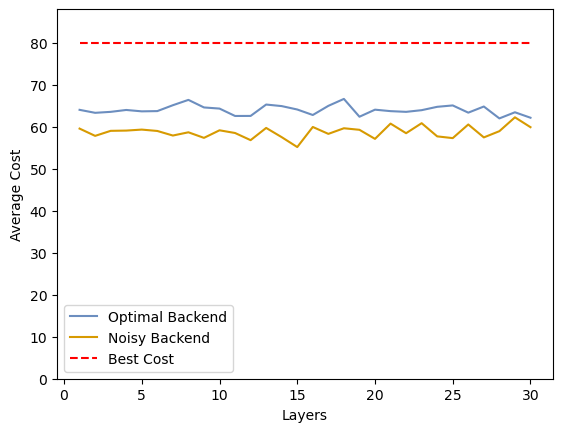

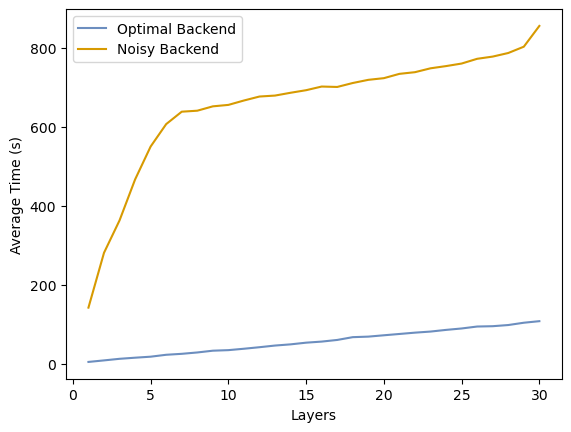

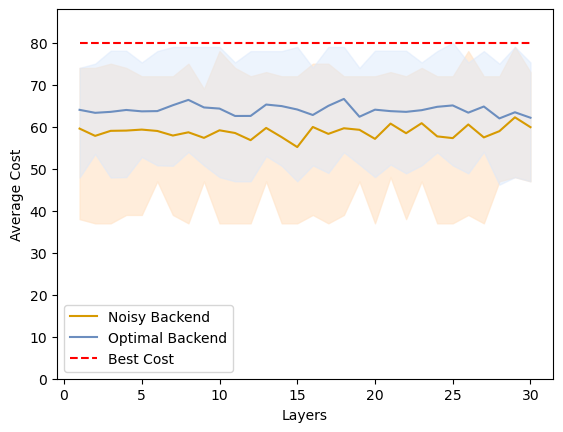

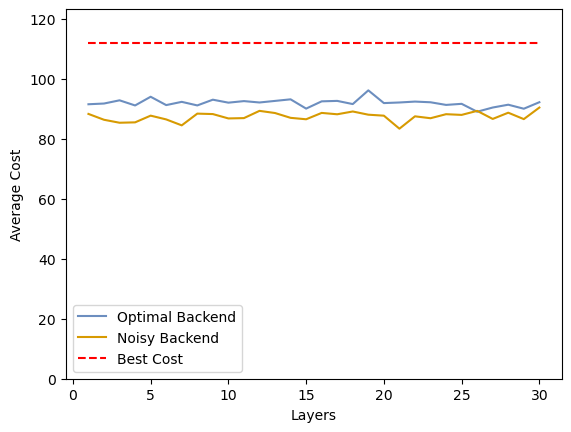

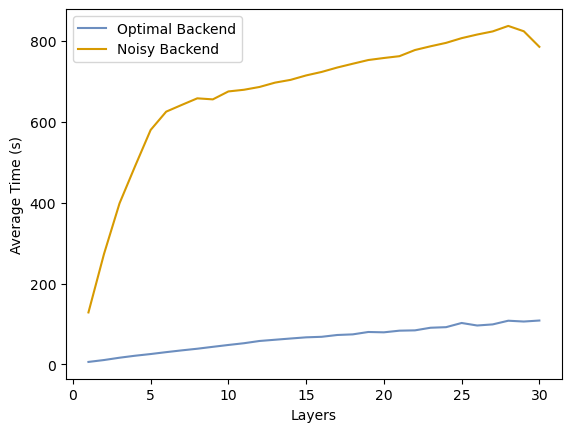

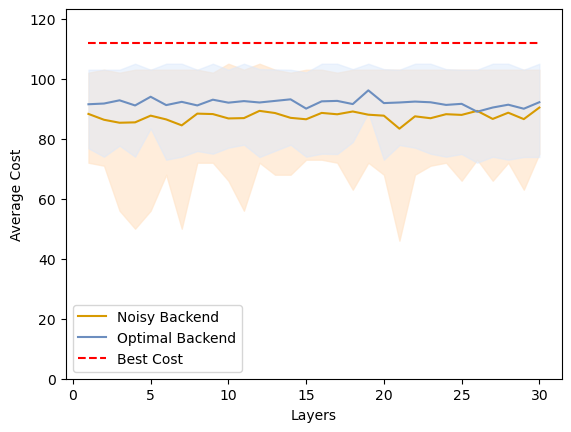

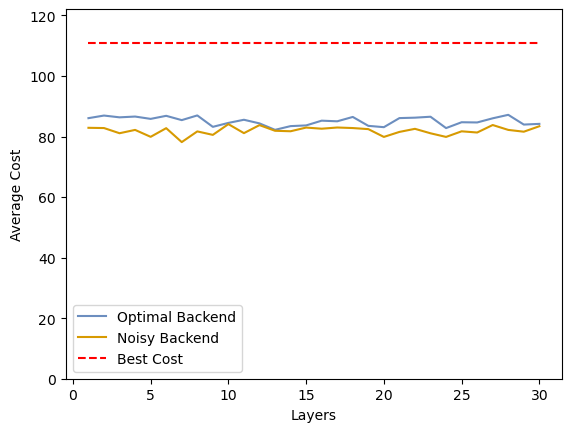

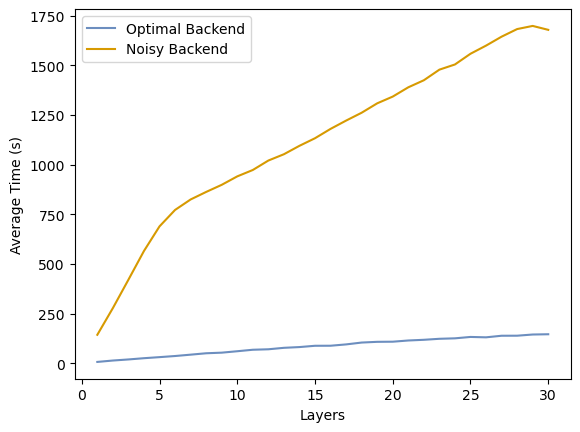

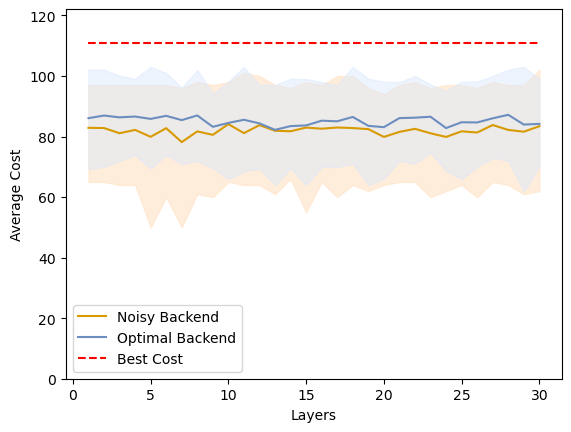

In [127]:
for number_of_nodes in range(3,10):
    plot_average_optimal_noisy(number_of_nodes)


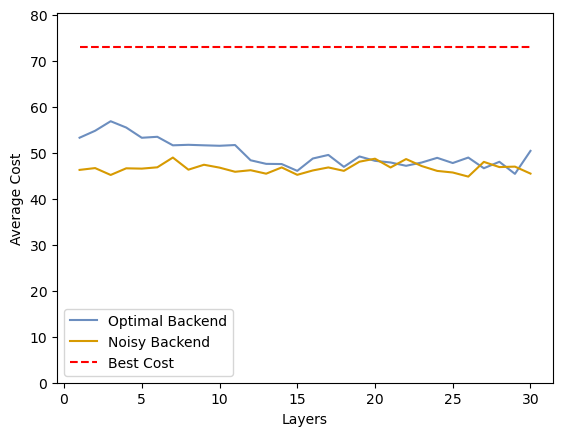

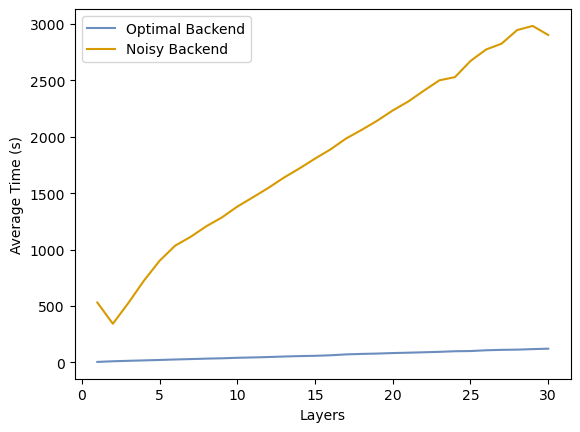

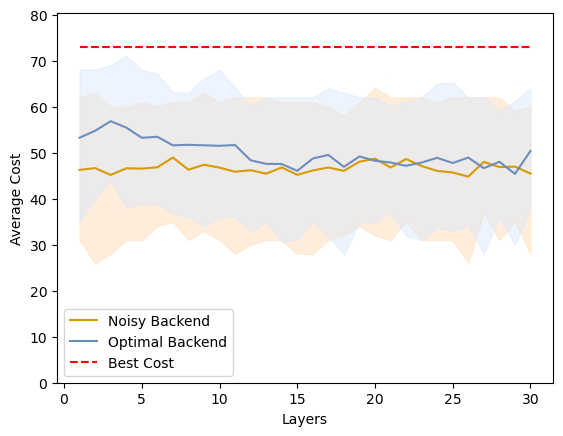

In [128]:
plot_average_optimal_noisy(10)